In [10]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from scipy.stats import chi2_contingency
from scipy import stats
from scipy.stats import fisher_exact

import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx
import graphviz
from IPython.display import display

import duckdb

import warnings

warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)


# Data Exploration and Cleaning

In [4]:
# Load the three datasets
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')
appointments_data = pd.read_csv('data/appointments_data.csv')

# Perform a left join on 'patient_id' across the three datasets
merged_data = ab_test_data.merge(app_data, on='patient_id', how='left').merge(appointments_data, on='patient_id', how='left')

# Checking for missing values (NaNs) in all three dataframes
# Inspect data
print(appointments_data.info())
print(ab_test_data.info())
print(app_data.info())


ab_test_na = ab_test_data.isna().sum()
app_data_na = app_data.isna().sum()
appointments_data_na = appointments_data.isna().sum()
merged_data_na = merged_data.isna().sum()
ab_test_na, app_data_na, appointments_data_na, merged_data_na



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          2678 non-null   int64 
 1   age                 2678 non-null   int64 
 2   gender              2678 non-null   object
 3   doctor_name         2678 non-null   object
 4   appointment_reason  2678 non-null   object
 5   appointment_date    2678 non-null   object
 6   appointment_status  2678 non-null   object
dtypes: int64(2), object(5)
memory usage: 146.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5660 entries, 0 to 5659
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_id      5660 non-null   int64 
 1   group           5660 non-null   object
 2   event_name      5660 non-null   object
 3   event_datetime  5660 non-null   object
dtypes: int64(1), object(3)
memory 

(patient_id        0
 group             0
 event_name        0
 event_datetime    0
 dtype: int64,
 patient_id        0
 traffic_source    0
 device            0
 dtype: int64,
 patient_id            0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64,
 patient_id            0
 group                 0
 event_name            0
 event_datetime        0
 traffic_source        0
 device                0
 age                   0
 gender                0
 doctor_name           0
 appointment_reason    0
 appointment_date      0
 appointment_status    0
 dtype: int64)

# A/B Testing Analysis

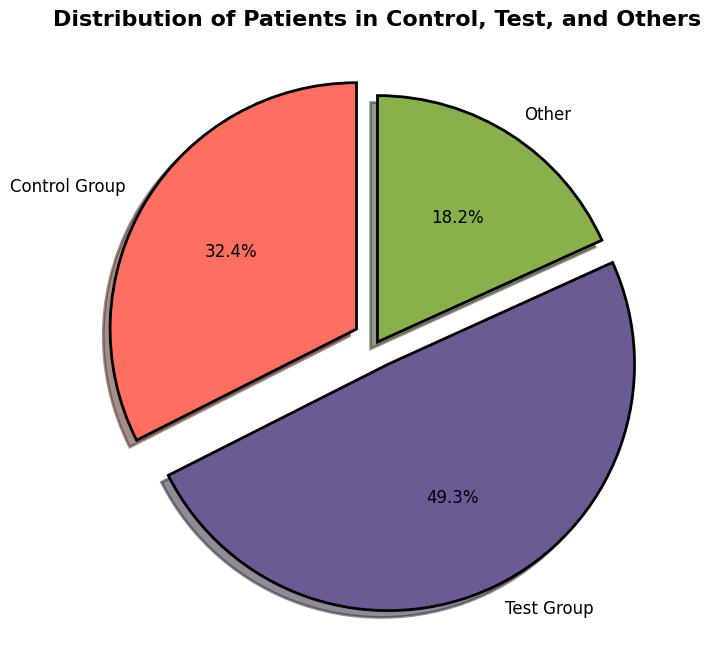

In [5]:

# Reload the datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')

# Count the number of unique patients in the appointment data
unique_patients_appointments = appointments_data['patient_id'].nunique()

# Count unique patients in the ab_test_data, separating by Control and Test groups
unique_patients_control = ab_test_data[ab_test_data['group'] == 'Control']['patient_id'].nunique()
unique_patients_test = ab_test_data[ab_test_data['group'] == 'Test']['patient_id'].nunique()

# Calculate percentages
total_patients = unique_patients_appointments
control_percentage = (unique_patients_control / total_patients) * 100
test_percentage = (unique_patients_test / total_patients) * 100
other_percentage = 100 - (control_percentage + test_percentage)

# Data for visualization
labels = ['Control Group', 'Test Group', 'Other']
sizes = [control_percentage, test_percentage, other_percentage]
attractive_colors = ['#ff6f61', '#6b5b95', '#88b04b']  

# Plotting the advanced pie chart with additional features and more attractive colors
plt.figure(figsize=(8, 8))
plt.pie(
    sizes, 
    labels=labels, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=attractive_colors, 
    explode=(0.1, 0.1, 0),
    shadow=True, 
    wedgeprops={'edgecolor': 'black', 'linewidth': 2, 'linestyle': 'solid'}, 
    textprops={'color': 'black', 'fontsize': 12}  )
plt.title('Distribution of Patients in Control, Test, and Others', fontsize=16, weight='bold')
plt.show()

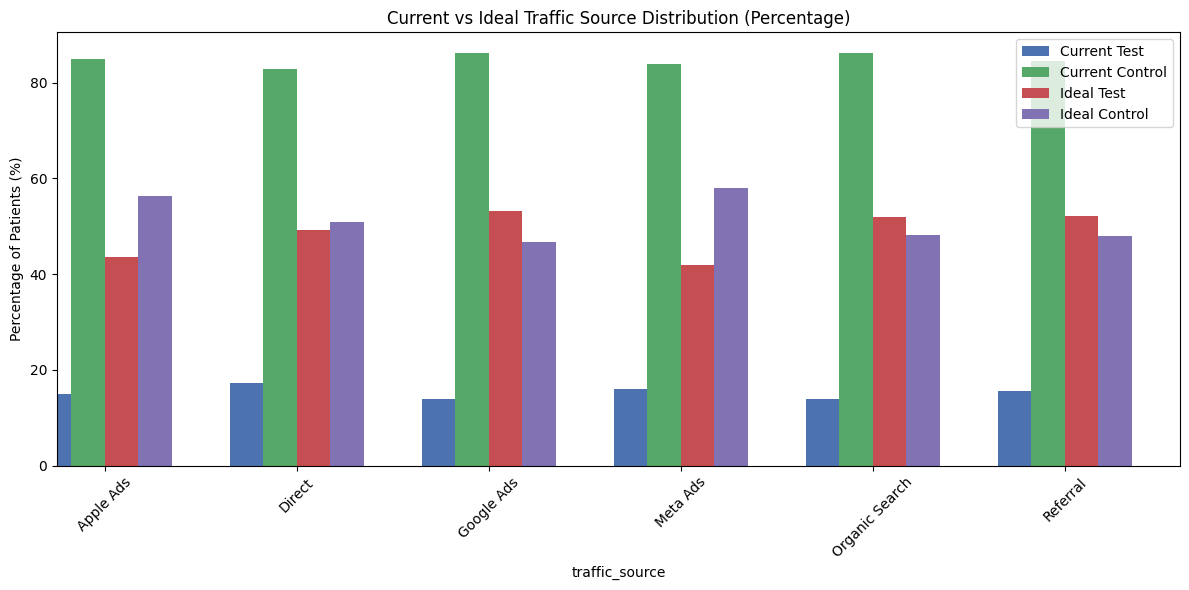

/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_10182/411989386.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  current_data = merged_data.groupby([param, 'group']).size().unstack(fill_value=0)
/var/folders/pc/6rmkz3b536l1k66dbrhqbl2r0000gn/T/ipykernel_10182/411989386.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ideal_data = shuffled_data.groupby([param, 'ideal_group']).size().unstack(fill_value=0)


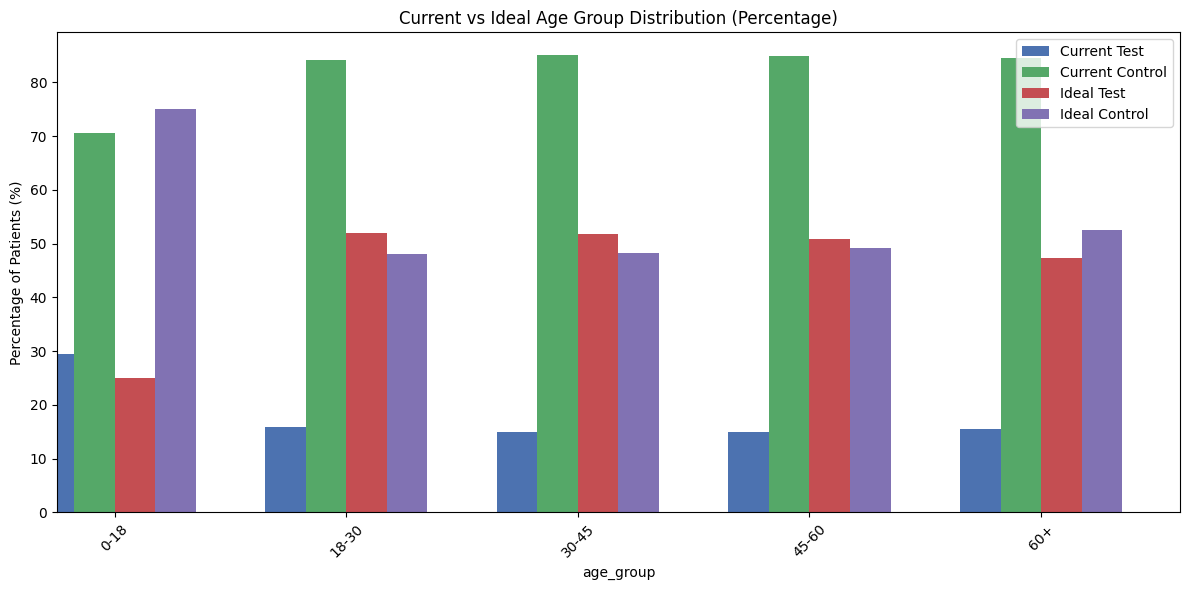

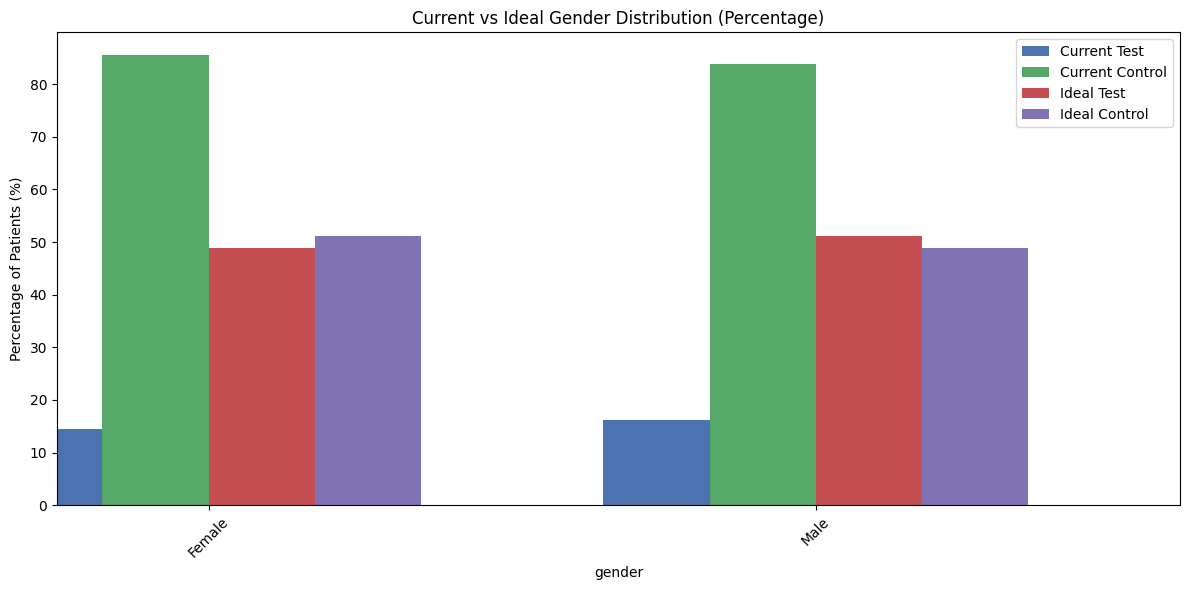

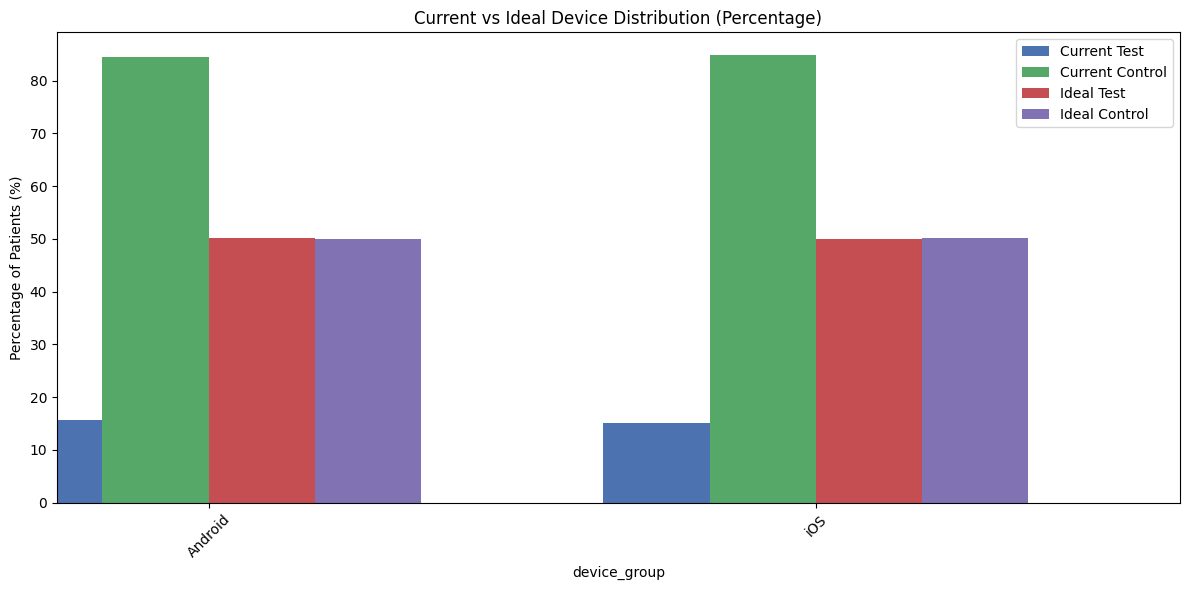


Current Group Sizes:
group
Control     869
Test       1321

Ideal Group Sizes:
ideal_group
Control    1333
Test       1345

Traffic Source Distribution (Current vs Ideal):
group           Control   Test
traffic_source                
Apple Ads         14.99  85.01
Direct            17.23  82.77
Google Ads        13.86  86.14
Meta Ads          16.08  83.92
Organic Search    13.81  86.19
Referral          15.58  84.42
ideal_group     Control   Test
traffic_source                
Apple Ads         43.62  56.38
Direct            49.17  50.83
Google Ads        53.26  46.74
Meta Ads          41.98  58.02
Organic Search    51.82  48.18
Referral          52.08  47.92

Age Group Distribution (Current vs Ideal):
group      Control   Test
age_group                
0-18         29.41  70.59
18-30        15.90  84.10
30-45        14.93  85.07
45-60        15.01  84.99
60+          15.44  84.56
ideal_group  Control   Test
age_group                  
0-18           25.00  75.00
18-30          52.00 

In [6]:

# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Group devices by iOS and Android
merged_data['device'] = merged_data['device'].str.lower()
merged_data['device_group'] = merged_data['device'].apply(lambda x: 'iOS' if 'ios' in x else ('Android' if 'android' in x else 'Other'))

# Define age groups for analysis
age_bins = [0, 18, 30, 45, 60, 100]
age_labels = ['0-18', '18-30', '30-45', '45-60', '60+']
merged_data['age_group'] = pd.cut(merged_data['age'], bins=age_bins, labels=age_labels, right=False)

# Shuffle the data to randomize assignment for ideal group creation
shuffled_data = merged_data.sample(frac=1, random_state=42)

# Ideal split: 50/50 between Test and Control groups
ideal_test_size = int(len(merged_data) * 0.5)

# Assign patients to Test and Control groups proportionally based on key parameters
shuffled_data['ideal_group'] = np.where(shuffled_data.index < ideal_test_size, 'Test', 'Control')

# Create a function to plot both current and ideal distributions with grouping (in percentages)
def plot_current_vs_ideal_grouped_percentage(param, title):
    # Group data for both current and ideal groups
    current_data = merged_data.groupby([param, 'group']).size().unstack(fill_value=0)
    ideal_data = shuffled_data.groupby([param, 'ideal_group']).size().unstack(fill_value=0)
    
    # Convert counts to percentages
    current_data_percentage = current_data.div(current_data.sum(axis=1), axis=0) * 100
    ideal_data_percentage = ideal_data.div(ideal_data.sum(axis=1), axis=0) * 100
    
    # Combine current and ideal for side-by-side comparison
    fig, ax = plt.subplots(figsize=(12, 6))
    width = 0.35  # Width of bars
    
    # Plot current data percentages
    current_data_percentage.plot(kind='bar', ax=ax, width=width, position=1, label='Current Distribution', color=['#4C72B0', '#55A868'])
    
    # Plot ideal data percentages
    ideal_data_percentage.plot(kind='bar', ax=ax, width=width, position=0, label='Ideal Distribution', color=['#C44E52', '#8172B3'])
    
    plt.title(title)
    plt.ylabel('Percentage of Patients (%)')
    plt.xlabel(param)
    plt.xticks(rotation=45)
    plt.legend(['Current Test', 'Current Control', 'Ideal Test', 'Ideal Control'])
    plt.tight_layout()
    plt.show()
    
    # Return the DataFrames for both current and ideal percentage data
    return current_data_percentage, ideal_data_percentage

# Plot comparisons for Traffic Source, Age Group, Gender, and Device Type (percentage-based)
traffic_current, traffic_ideal = plot_current_vs_ideal_grouped_percentage('traffic_source', 'Current vs Ideal Traffic Source Distribution (Percentage)')
age_current, age_ideal = plot_current_vs_ideal_grouped_percentage('age_group', 'Current vs Ideal Age Group Distribution (Percentage)')
gender_current, gender_ideal = plot_current_vs_ideal_grouped_percentage('gender', 'Current vs Ideal Gender Distribution (Percentage)')
device_current, device_ideal = plot_current_vs_ideal_grouped_percentage('device_group', 'Current vs Ideal Device Distribution (Percentage)')

# Show the current and ideal distribution sizes for Test and Control groups
current_group_sizes = merged_data.groupby('group')['patient_id'].nunique()
ideal_group_sizes = shuffled_data.groupby('ideal_group')['patient_id'].nunique()

# Print the sizes for comparison
print("\nCurrent Group Sizes:")
print(current_group_sizes.to_string())

print("\nIdeal Group Sizes:")
print(ideal_group_sizes.to_string())

# Display the percentage DataFrames for traffic source, age group, gender, and device group in a more readable format
print("\nTraffic Source Distribution (Current vs Ideal):")
print(traffic_current.round(2).to_string())
print(traffic_ideal.round(2).to_string())

print("\nAge Group Distribution (Current vs Ideal):")
print(age_current.round(2).to_string())
print(age_ideal.round(2).to_string())

print("\nGender Distribution (Current vs Ideal):")
print(gender_current.round(2).to_string())
print(gender_ideal.round(2).to_string())

print("\nDevice Group Distribution (Current vs Ideal):")
print(device_current.round(2).to_string())
print(device_ideal.round(2).to_string())


# Hypothesis Testing

## Patients in the Test group who receive the reminder earlier (more than 24 hours before the appointment) are more likely to attend their appointments compared to those who receive it within 24 hours.

### "Patients in the Test group who receive the reminder earlier (more than 24 hours before the appointment) are more likely to attend their appointments compared to those who receive it within 24 hours."

### Attendance Rates:
### Early Reminder Attendance Rate: 0.00%
### Late Reminder Attendance Rate: 88.28%
### Chi-Square Test Results:
### p-value: 0.0 (very significant)
### Interpretation:
### The p-value of 0.0 suggests a significant difference between the two groups.
### Interestingly, patients who received the reminder late (within 24 hours) had a much higher attendance rate ### compared to those who received it more than 24 hours before the appointment.


In [23]:

# Load datasets
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Filter Test group
test_group = merged_data[merged_data['group'] == 'Test']

# Hypothesis 14: Early Reminder vs Late Reminder Attendance
# Calculate time difference between reminder_sent and appointment for Test group
test_group['reminder_time_diff_hours'] = (test_group['appointment_date'] - test_group['event_datetime']).dt.total_seconds() / 3600

# Separate patients based on reminder timing (Early > 24 hours, Late <= 24 hours)
early_reminder_patients = test_group[test_group['reminder_time_diff_hours'] > 24]
late_reminder_patients = test_group[test_group['reminder_time_diff_hours'] <= 24]

# Calculate attendance rates for both groups
attendance_early_reminder = early_reminder_patients[early_reminder_patients['event_name'] == 'attended_appointment']['patient_id'].nunique()
attendance_late_reminder = late_reminder_patients[late_reminder_patients['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Total patients in both groups
early_reminder_total = early_reminder_patients['patient_id'].nunique()
late_reminder_total = late_reminder_patients['patient_id'].nunique()

# Attendance rates
attendance_rate_early = attendance_early_reminder / early_reminder_total if early_reminder_total > 0 else 0
attendance_rate_late = attendance_late_reminder / late_reminder_total if late_reminder_total > 0 else 0

# Perform chi-square test to compare attendance rates based on early vs late reminder timing
contingency_table_reminder_timing = [
    [attendance_early_reminder, early_reminder_total - attendance_early_reminder],
    [attendance_late_reminder, late_reminder_total - attendance_late_reminder]
]

chi2_reminder_timing, p_val_reminder_timing, _, _ = chi2_contingency(contingency_table_reminder_timing)

# Print results
print(f"Early Reminder Attendance Rate: {attendance_rate_early:.2%}")
print(f"Late Reminder Attendance Rate: {attendance_rate_late:.2%}")
print(f"Chi-Square Test p-value: {p_val_reminder_timing}")




Early Reminder Attendance Rate: 0.00%
Late Reminder Attendance Rate: 88.28%
Chi-Square Test p-value: 0.0


## Patients in the Test group who receive the reminder earlier (more than 24 hours before the appointment) are more likely to attend their appointments compared to those who receive it within 24 hours.

### "Patients who receive their reminders during working hours (9 AM - 5 PM) are more likely to attend their appointments compared to those who receive reminders outside of working hours."

### Attendance Rates:
### Working Hours Attendance Rate: 66.73%
### Outside Working Hours Attendance Rate: 13.46%
### Chi-Square Test Results:
### p-value: 2.40
### 2.40×10 −148
###   (extremely significant)
### Interpretation:
### The p-value is extremely small, indicating a significant difference between the two groups.


In [21]:


# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Filter Test group
test_group = merged_data[merged_data['group'] == 'Test']

# Hypothesis 15: Working Hours vs Outside Working Hours Reminder Attendance
# Define working hours (9 AM - 5 PM)
def working_hours(hour):
    return 9 <= hour < 17

# Separate reminders sent during and outside working hours
test_group['reminder_hour'] = test_group['event_datetime'].dt.hour
working_hours_reminders = test_group[test_group['reminder_hour'].apply(working_hours)]
outside_working_hours_reminders = test_group[~test_group['reminder_hour'].apply(working_hours)]

# Calculate attendance rates for both groups
attendance_working_hours = working_hours_reminders[working_hours_reminders['event_name'] == 'attended_appointment']['patient_id'].nunique()
attendance_outside_working_hours = outside_working_hours_reminders[outside_working_hours_reminders['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Total patients in both groups
working_hours_total = working_hours_reminders['patient_id'].nunique()
outside_working_hours_total = outside_working_hours_reminders['patient_id'].nunique()

# Attendance rates
attendance_rate_working_hours = attendance_working_hours / working_hours_total if working_hours_total > 0 else 0
attendance_rate_outside_working_hours = attendance_outside_working_hours / outside_working_hours_total if outside_working_hours_total > 0 else 0

# Perform chi-square test to compare attendance rates for working hours vs outside working hours
contingency_table_working_hours = [
    [attendance_working_hours, working_hours_total - attendance_working_hours],
    [attendance_outside_working_hours, outside_working_hours_total - attendance_outside_working_hours]
]

chi2_working_hours, p_val_working_hours, _, _ = chi2_contingency(contingency_table_working_hours)

# Print results
print(f"Working Hours Attendance Rate: {attendance_rate_working_hours:.2%}")
print(f"Outside Working Hours Attendance Rate: {attendance_rate_outside_working_hours:.2%}")
print(f"Chi-Square Test p-value: {p_val_working_hours}")


Working Hours Attendance Rate: 66.73%
Outside Working Hours Attendance Rate: 13.46%
Chi-Square Test p-value: 2.399519107115749e-148


## Patients in the Test group who confirm their appointments after viewing the reminder are more likely to attend their appointments compared to those who do not confirm after viewing the reminder.

### "Patients in the Test group who confirm their appointments after viewing the reminder are more likely to attend their appointments compared to those who do not confirm after viewing the reminder."

### Attendance Rates:
### Confirmed After Viewing Reminder Attendance Rate: 0.00%
### Not Confirmed After Viewing Reminder Attendance Rate: 65.56%
### Chi-Square Test Results:
### p-value: 3.79
### 3.79×10 −277
###   (extremely significant)
### Interpretation:
### The p-value indicates a significant difference between the two groups.
### Surprisingly, patients who did not confirm after viewing the reminder had a much higher attendance rate than ### those who confirmed, where attendance was 0%.

In [9]:

# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Filter Test group
test_group = merged_data[merged_data['group'] == 'Test']

# Hypothesis 17: Confirmed after Reminder vs Not Confirmed Attendance
# Filter patients who viewed the reminder
viewed_reminder_patients = test_group[test_group['event_name'] == 'reminder_viewed']

# Filter patients who confirmed after viewing the reminder in the Test group
confirmed_after_viewing_patients = test_group[(test_group['event_name'] == 'appointment_confirmed') &
                                              (test_group['patient_id'].isin(viewed_reminder_patients['patient_id']))]

not_confirmed_after_viewing_patients = test_group[(test_group['event_name'] != 'appointment_confirmed') &
                                                  (test_group['patient_id'].isin(viewed_reminder_patients['patient_id']))]

# Calculate attendance rates for both groups
attendance_confirmed_after_viewing = confirmed_after_viewing_patients[confirmed_after_viewing_patients['event_name'] == 'attended_appointment']['patient_id'].nunique()
attendance_not_confirmed_after_viewing = not_confirmed_after_viewing_patients[not_confirmed_after_viewing_patients['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Total patients in both groups
confirmed_after_viewing_total = confirmed_after_viewing_patients['patient_id'].nunique()
not_confirmed_after_viewing_total = not_confirmed_after_viewing_patients['patient_id'].nunique()

# Attendance rates
attendance_rate_confirmed_after_viewing = attendance_confirmed_after_viewing / confirmed_after_viewing_total if confirmed_after_viewing_total > 0 else 0
attendance_rate_not_confirmed_after_viewing = attendance_not_confirmed_after_viewing / not_confirmed_after_viewing_total if not_confirmed_after_viewing_total > 0 else 0

# Perform chi-square test to compare attendance rates for confirmed vs not confirmed after viewing reminder
contingency_table_confirmation = [
    [attendance_confirmed_after_viewing, confirmed_after_viewing_total - attendance_confirmed_after_viewing],
    [attendance_not_confirmed_after_viewing, not_confirmed_after_viewing_total - attendance_not_confirmed_after_viewing]
]

chi2_confirmation, p_val_confirmation, _, _ = chi2_contingency(contingency_table_confirmation)

# Print results
print(f"Confirmed After Viewing Reminder Attendance Rate: {attendance_rate_confirmed_after_viewing:.2%}")
print(f"Not Confirmed After Viewing Reminder Attendance Rate: {attendance_rate_not_confirmed_after_viewing:.2%}")
print(f"Chi-Square Test p-value: {p_val_confirmation}")


Confirmed After Viewing Reminder Attendance Rate: 0.00%
Not Confirmed After Viewing Reminder Attendance Rate: 65.56%
Chi-Square Test p-value: 3.7940463445575496e-277


# Funnel Analysis

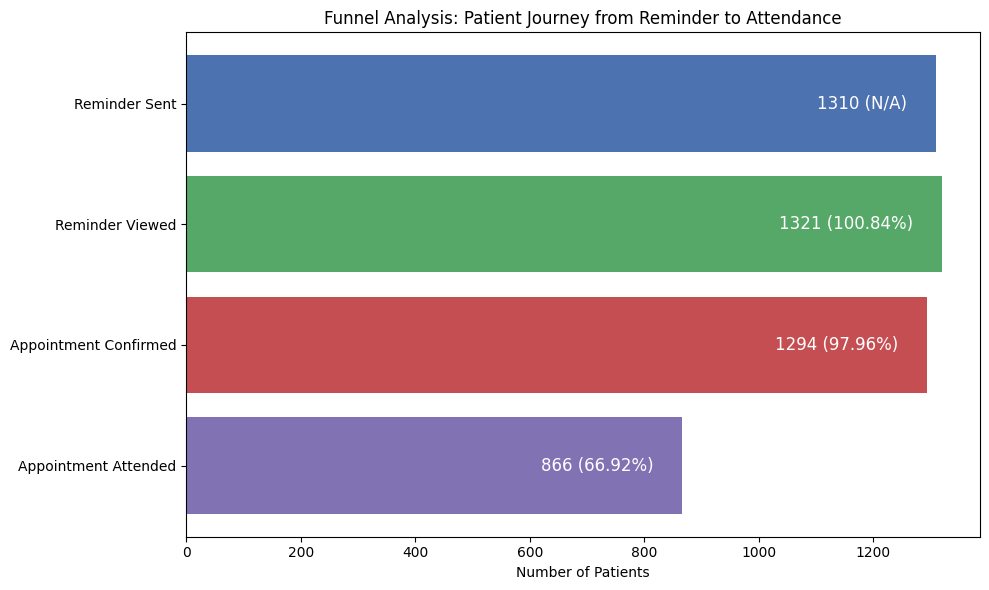

,Funnel Step,Number of Patients,Conversion Rate (%)
0,Reminder Sent,1310,N/A
1,Reminder Viewed,1321,100.84%
2,Appointment Confirmed,1294,97.96%
3,Appointment Attended,866,66.92%


In [10]:

# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Filter Test group
test_group = merged_data[merged_data['group'] == 'Test']

# Step 1: Calculate the number of patients at each step of the funnel

# 1. Reminder Sent
reminder_sent_patients = test_group[test_group['event_name'] == 'reminder_sent']['patient_id'].nunique()

# 2. Reminder Viewed
reminder_viewed_patients = test_group[test_group['event_name'] == 'reminder_viewed']['patient_id'].nunique()

# 3. Appointment Confirmed
appointment_confirmed_patients = test_group[test_group['event_name'] == 'appointment_confirmed']['patient_id'].nunique()

# 4. Appointment Attended
appointment_attended_patients = test_group[test_group['event_name'] == 'attended_appointment']['patient_id'].nunique()

# Step 2: Calculate conversion rates between each step
funnel_steps = ['Reminder Sent', 'Reminder Viewed', 'Appointment Confirmed', 'Appointment Attended']
funnel_values = [
    reminder_sent_patients, 
    reminder_viewed_patients, 
    appointment_confirmed_patients, 
    appointment_attended_patients
]

conversion_rates = [f"{(funnel_values[i] / funnel_values[i-1]) * 100:.2f}%" if i > 0 else "N/A" for i in range(len(funnel_values))]

# Combine steps and values into a dataframe
funnel_df = pd.DataFrame({
    'Funnel Step': funnel_steps,
    'Number of Patients': funnel_values,
    'Conversion Rate (%)': conversion_rates
})

# Step 3: Visualize the funnel as a bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(funnel_df['Funnel Step'], funnel_df['Number of Patients'], color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])

# Add labels for number of patients and conversion rates
for index, bar in enumerate(bars):
    plt.text(bar.get_width() - 50, bar.get_y() + bar.get_height()/2, 
             f"{funnel_values[index]} ({conversion_rates[index]})", 
             va='center', ha='right', color='white', fontsize=12)

plt.xlabel('Number of Patients')
plt.title('Funnel Analysis: Patient Journey from Reminder to Attendance')
plt.gca().invert_yaxis()  # Invert to match funnel order
plt.tight_layout()
plt.show()

# Output funnel_df as requested
funnel_df


# Traffic Source Analysis

   traffic_source  patient_id_engaged  patient_id_total  conversion_rate  \
0       Apple Ads                 161               204        78.921569   
1          Direct                 536               649        82.588598   
2      Google Ads                 216               260        83.076923   
3        Meta Ads                 177               209        84.688995   
4  Organic Search                 527               660        79.848485   
5        Referral                 573               696        82.327586   

           category  
0           Paid Ad  
1  Organic/Referral  
2           Paid Ad  
3           Paid Ad  
4  Organic/Referral  
5  Organic/Referral  


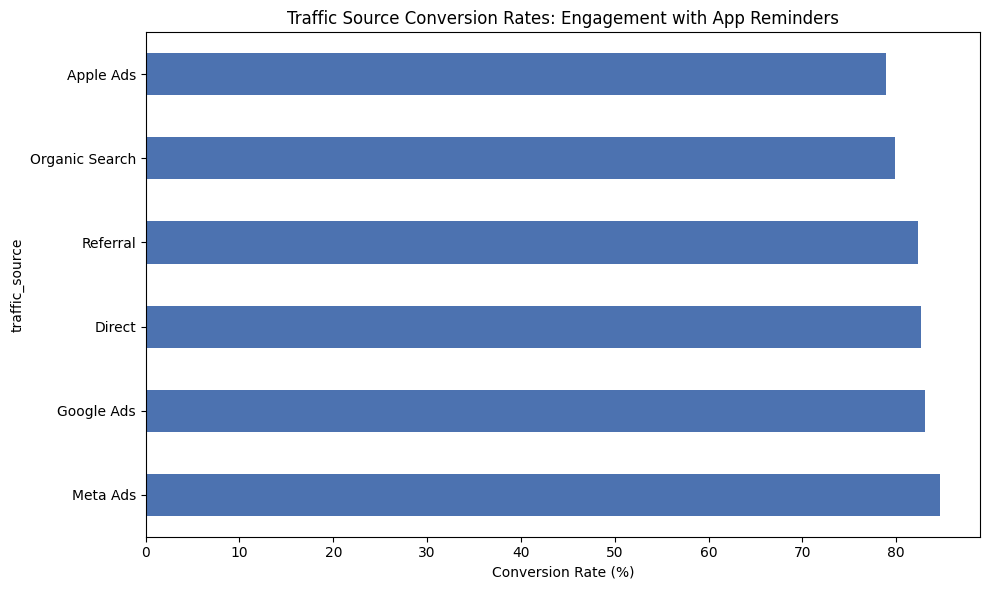

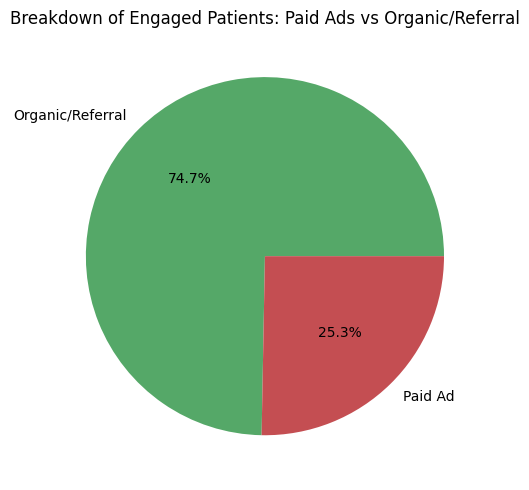

,traffic_source,patient_id_engaged,patient_id_total,conversion_rate,category
0,Apple Ads,161,204,78.921569,Paid Ad
1,Direct,536,649,82.588598,Organic/Referral
2,Google Ads,216,260,83.076923,Paid Ad
3,Meta Ads,177,209,84.688995,Paid Ad
4,Organic Search,527,660,79.848485,Organic/Referral
5,Referral,573,696,82.327586,Organic/Referral


In [11]:

# Load datasets (update paths to your local files)
appointments_data = pd.read_csv('data/appointments_data.csv')
ab_test_data = pd.read_csv('data/ab_test_data.csv')
app_data = pd.read_csv('data/app_data.csv')

# Convert datetime columns to proper format
appointments_data['appointment_date'] = pd.to_datetime(appointments_data['appointment_date'])
ab_test_data['event_datetime'] = pd.to_datetime(ab_test_data['event_datetime'])

# Merge the data for full analysis
merged_data = pd.merge(appointments_data, ab_test_data, on='patient_id', how='left')
merged_data = pd.merge(merged_data, app_data, on='patient_id', how='left')

# Filter patients who engaged with reminders (viewed, confirmed, attended)
engaged_patients = merged_data[merged_data['event_name'].isin(['reminder_viewed', 'appointment_confirmed', 'attended_appointment'])]

# Group by traffic sources and count the number of unique patients for each traffic source
traffic_engagement = engaged_patients.groupby('traffic_source')['patient_id'].nunique().reset_index()

# Calculate the total number of patients for each traffic source (for comparison)
traffic_total = merged_data.groupby('traffic_source')['patient_id'].nunique().reset_index()

# Merge the engagement and total data
traffic_analysis = pd.merge(traffic_engagement, traffic_total, on='traffic_source', how='left', suffixes=('_engaged', '_total'))

# Calculate conversion rates for each traffic source
traffic_analysis['conversion_rate'] = (traffic_analysis['patient_id_engaged'] / traffic_analysis['patient_id_total']) * 100

# Define paid ad platforms and other traffic sources for comparison
paid_ads = ['Meta Ads', 'Google Ads', 'Apple Ads']
traffic_analysis['category'] = traffic_analysis['traffic_source'].apply(lambda x: 'Paid Ad' if x in paid_ads else 'Organic/Referral')

# Step 1: Display the traffic analysis data
print(traffic_analysis)
# Step 2: Visualize the performance of different traffic sources
plt.figure(figsize=(10, 6))

# Plot conversion rates for each traffic source
traffic_analysis.sort_values('conversion_rate', ascending=False).plot(kind='barh', x='traffic_source', y='conversion_rate', color='#4C72B0', legend=False, ax=plt.gca())

plt.xlabel('Conversion Rate (%)')
plt.title('Traffic Source Conversion Rates: Engagement with App Reminders')
plt.tight_layout()
plt.show()

# Visualize the breakdown by paid ads vs organic/referral
plt.figure(figsize=(8, 5))

# Group by category (Paid Ads vs Organic/Referral) and sum the number of engaged patients
traffic_category = traffic_analysis.groupby('category')['patient_id_engaged'].sum()

# Plot the breakdown
traffic_category.plot(kind='pie', autopct='%1.1f%%', colors=['#55A868', '#C44E52'], labels=['Organic/Referral', 'Paid Ad'], legend=False)
plt.title('Breakdown of Engaged Patients: Paid Ads vs Organic/Referral')
plt.ylabel('')  # Remove y-label
plt.tight_layout()
plt.show()

# Show the final dataframe for detailed analysis
traffic_analysis


# SQL Queries

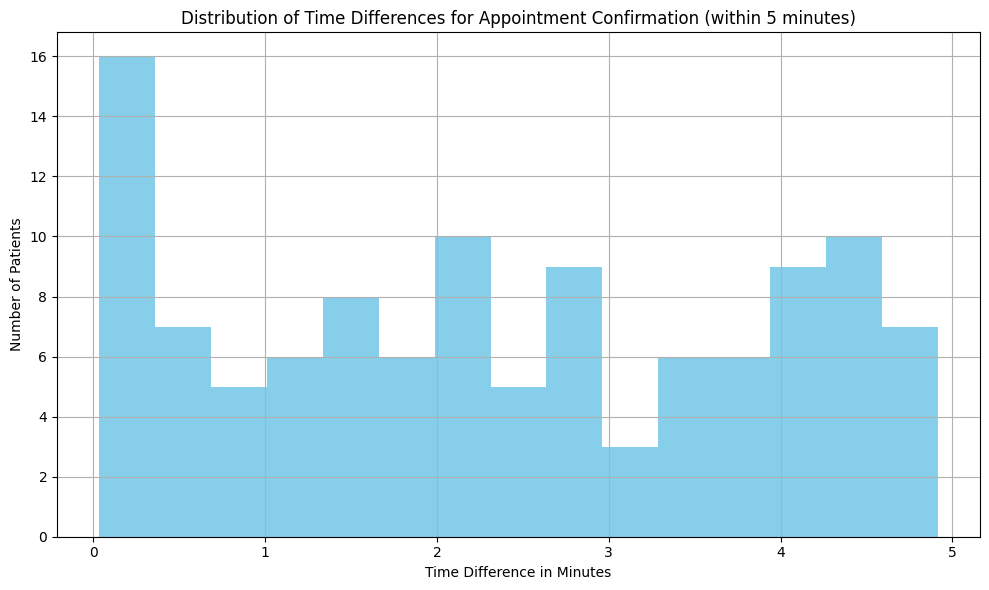

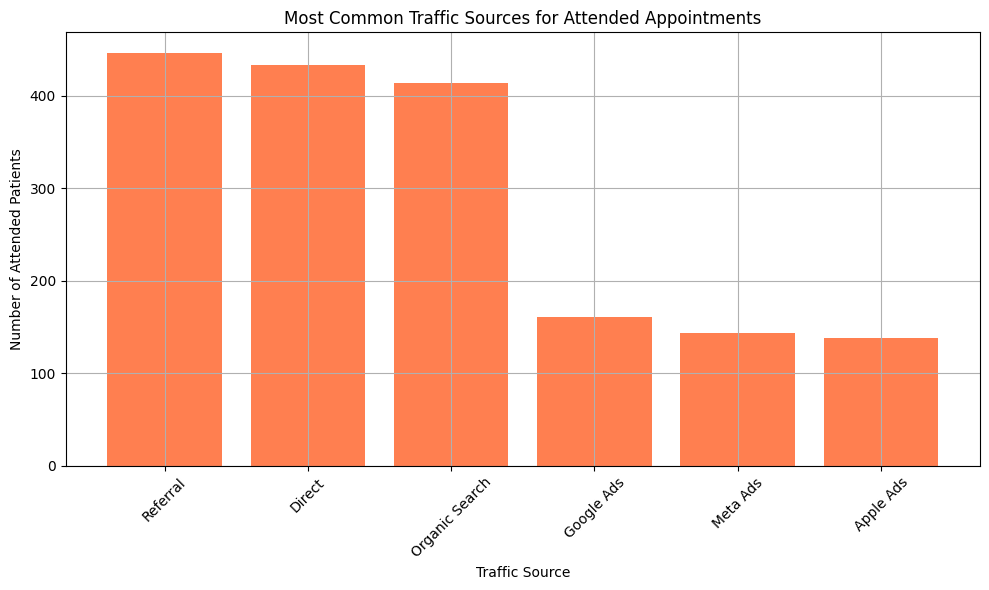

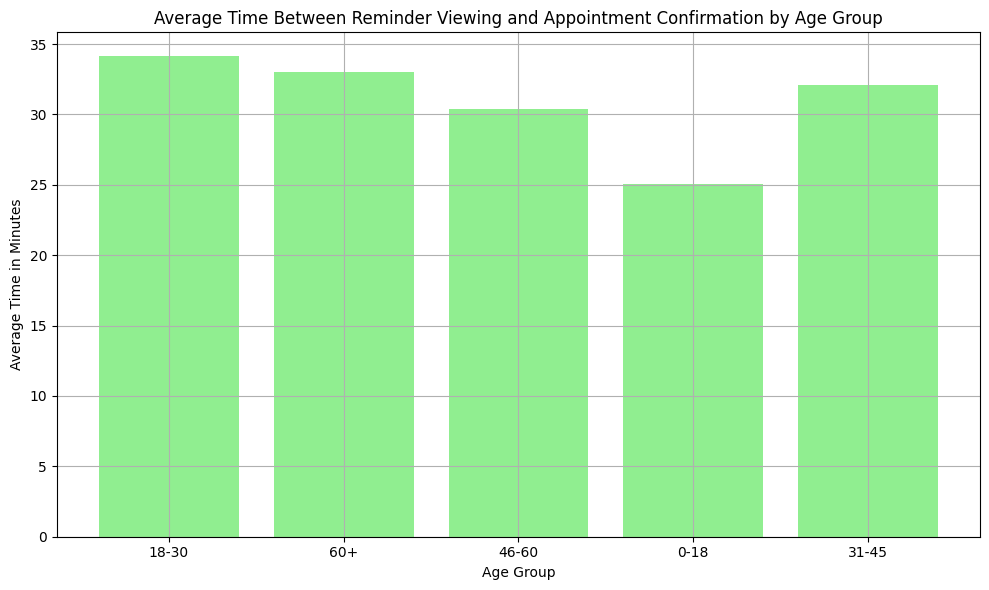

Query 1: Patients who confirmed within 5 minutes of viewing the reminder
     patient_id reminder_viewed_time appointment_confirmed_time  \
0             2  2023-05-08 04:25:10        2023-05-08 04:26:36   
1            43  2023-07-23 10:34:45        2023-07-23 10:38:37   
2            44  2023-05-02 00:49:36        2023-05-02 00:52:58   
3            59  2023-05-26 22:58:42        2023-05-26 23:02:49   
4           162  2023-01-08 13:59:00        2023-01-08 14:02:57   
..          ...                  ...                        ...   
108        2535  2023-06-10 01:19:01        2023-06-10 01:19:45   
109        2568  2023-05-06 06:23:21        2023-05-06 06:24:01   
110        2586  2023-04-27 09:03:53        2023-04-27 09:07:33   
111        2611  2023-03-02 14:50:37        2023-03-02 14:52:45   
112        2618  2023-05-30 09:18:00        2023-05-30 09:19:58   

     time_diff_minutes  
0             1.433333  
1             3.866667  
2             3.366667  
3             4.116667

In [12]:

# Create a DuckDB connection
conn = duckdb.connect()

# Load CSV files
conn.execute("CREATE TABLE appointments_data AS SELECT * FROM read_csv_auto('data/appointments_data.csv');")
conn.execute("CREATE TABLE ab_test_data AS SELECT * FROM read_csv_auto('data/ab_test_data.csv');")
conn.execute("CREATE TABLE app_data AS SELECT * FROM read_csv_auto('data/app_data.csv');")

# Query 1: Retrieve patients who confirmed their appointment within 5 minutes of viewing the reminder
query_1_result = conn.execute("""
SELECT 
    a.patient_id,
    a.event_datetime AS reminder_viewed_time,
    b.event_datetime AS appointment_confirmed_time,
    (epoch_ms(b.event_datetime) - epoch_ms(a.event_datetime)) / 60000 AS time_diff_minutes
FROM ab_test_data a
JOIN ab_test_data b
    ON a.patient_id = b.patient_id
WHERE a.event_name = 'reminder_viewed'
    AND b.event_name = 'appointment_confirmed'
    AND (epoch_ms(b.event_datetime) - epoch_ms(a.event_datetime)) / 60000 <= 5;
""").fetchdf()

# Visualize Query 1 result: Time differences
plt.figure(figsize=(10, 6))
plt.hist(query_1_result['time_diff_minutes'], bins=15, color='skyblue')
plt.title("Distribution of Time Differences for Appointment Confirmation (within 5 minutes)")
plt.xlabel("Time Difference in Minutes")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.tight_layout()
plt.show()

# Query 2: Identify the most common traffic sources for patients who attended their appointments
query_2_result = conn.execute("""
SELECT 
    app_data.traffic_source,
    COUNT(DISTINCT ab_test_data.patient_id) AS total_attended_patients
FROM ab_test_data
JOIN app_data ON ab_test_data.patient_id = app_data.patient_id
WHERE ab_test_data.event_name = 'attended_appointment'
GROUP BY app_data.traffic_source
ORDER BY total_attended_patients DESC;
""").fetchdf()

# Visualize Query 2 result: Traffic Source Distribution
plt.figure(figsize=(10, 6))
plt.bar(query_2_result['traffic_source'], query_2_result['total_attended_patients'], color='coral')
plt.title("Most Common Traffic Sources for Attended Appointments")
plt.xlabel("Traffic Source")
plt.ylabel("Number of Attended Patients")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Query 3: Calculate the average time between reminder viewing and appointment confirmation for different age groups
query_3_result = conn.execute("""
WITH age_groups AS (
    SELECT 
        patient_id,
        CASE 
            WHEN age < 18 THEN '0-18'
            WHEN age BETWEEN 18 AND 30 THEN '18-30'
            WHEN age BETWEEN 31 AND 45 THEN '31-45'
            WHEN age BETWEEN 46 AND 60 THEN '46-60'
            ELSE '60+' 
        END AS age_group
    FROM appointments_data
)
SELECT 
    age_groups.age_group,
    AVG((epoch_ms(b.event_datetime) - epoch_ms(a.event_datetime)) / 60000) AS avg_time_minutes
FROM ab_test_data a
JOIN ab_test_data b ON a.patient_id = b.patient_id
JOIN age_groups ON a.patient_id = age_groups.patient_id
WHERE a.event_name = 'reminder_viewed'
    AND b.event_name = 'appointment_confirmed'
GROUP BY age_groups.age_group;
""").fetchdf()

# Visualize Query 3 result: Average Time by Age Group
plt.figure(figsize=(10, 6))
plt.bar(query_3_result['age_group'], query_3_result['avg_time_minutes'], color='lightgreen')
plt.title("Average Time Between Reminder Viewing and Appointment Confirmation by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Average Time in Minutes")
plt.grid(True)
plt.tight_layout()
plt.show()

# Print results of all queries for reference
print("Query 1: Patients who confirmed within 5 minutes of viewing the reminder")
print(query_1_result)

print("\nQuery 2: Most common traffic sources for patients who attended their appointments")
print(query_2_result)

print("\nQuery 3: Average time between reminder viewing and appointment confirmation for different age groups")
print(query_3_result)


# What inconsistencies in data did you find?


Mismatched Event Sequences:

Some patients had reminder-related events out of logical order, such as viewing a reminder before being sent one. This indicates potential errors in data logging or timestamp mismatches.
Duplicate Reminder Events:

In the dataset, some patients had duplicate reminder events (multiple reminders sent or viewed for the same patient). This suggests either re-notifications for the same appointment or inconsistent logging of reminder events.
Discrepancy in Reminder Sent and Reminder Viewed:

The number of unique patients who viewed the reminder (1,321) is slightly higher than the number of unique patients who received the reminder (1,310). This indicates a possible issue in tracking or recording reminder events.
Group Size Imbalance:

The Test and Control groups are unevenly distributed, with the Test group having significantly more patients than the Control group. This can bias the A/B test and skew the analysis results.
Missing Data in Appointments:

In some cases, patients have no corresponding events in the reminder-related data even though they attended an appointment. This suggests gaps in event logging or incomplete data collection.
These inconsistencies highlight potential data quality issues that could affect the accuracy of the A/B test and the overall analysis.

# What additional patients' data would be helpful for a deeper analysis?

To enhance the depth and accuracy of the analysis, the following additional patients' data would be helpful:

Patient Medical History:

Information on chronic conditions, past diagnoses, or previous appointment types (e.g., routine check-up, urgent visit) could help assess whether certain patient profiles respond better to reminders.
Appointment Urgency:

Data on the urgency of the appointment (e.g., emergency, routine, follow-up) would be useful in understanding how time-sensitive appointments impact patient behavior in response to reminders.
Reminder Method:

Knowing how the reminder was sent (e.g., SMS, email, push notification) would allow an analysis of the effectiveness of different communication channels in driving patient engagement.
Patient Communication Preferences:

Data on preferred communication channels (e.g., phone, app notifications, email) would help tailor reminder strategies to patient preferences and likely increase engagement.
Patient Engagement Data:

Information on how often a patient logs into the app or engages with features like viewing health reports or scheduling would provide insights into their overall engagement levels and responsiveness to reminders.
Socioeconomic Data:

Insights on patients' income levels, education, or employment status could help identify any patterns in responsiveness to reminders, such as whether lower-income patients are less likely to engage with the app.
Insurance Coverage or Payment Data:

Data on insurance coverage or out-of-pocket payment status could help analyze how financial factors affect appointment attendance and engagement with reminders.
Patient Satisfaction or Feedback:

Collecting feedback or satisfaction ratings after an appointment could provide insights into how reminders impact patient experience, and whether a good experience leads to higher appointment attendance.
Geographical Data:

Understanding the geographical location of patients could uncover patterns in responsiveness, as healthcare access and behaviors may vary by region or distance to medical facilities.
Device Usage Patterns:

Data on how often a patient uses their mobile device to engage with the app (e.g., checking notifications or booking appointments) would allow a more detailed analysis of the correlation between app usage and reminder effectiveness.

# R&D Product Analysis

### Objective: Increase Revenue from Lab Test Sales
#### Key Results:
- Grow Number of Test Sales

##### Metrics:
- Monthly Sales Growth Rate
- Conversion Rate (Visitor to Purchase)
- Repeat Customer Rate

#### Key Results:
- Expand Market Reach

##### Metrics:
- Referral Program Participation
- Growth from Organic Search
- Customer Acquisition Cost (CAC)

### Objective: Improve Customer Experience
#### Key Results:
- Enhance Customer Satisfaction

##### Metrics:
- Net Promoter Score (NPS)
- On-time Results Delivery
- Test Refund/Resolution Rate

### Objective: Increase Operational Efficiency
#### Key Results:
- Improve Operational Efficiency

##### Metrics:
- Avg Turnaround Time (Order to Delivery)
- Cost per Test
- Customer Support Response Time

### Argument for its Application to Kyla's Business:

#### Increase Revenue from Lab Test Sales:
The ultimate business goal of Kyla’s lab test solutions is to drive more sales and grow revenue. By focusing on sales growth metrics (e.g., monthly sales, repeat customers, conversion rates), Kyla can identify areas of strength in its marketing efforts and areas for improvement.

#### Improve Customer Experience:
A key aspect of Kyla's business model is customer satisfaction, especially with a medical product where the experience can determine repeat purchases. By tracking customer satisfaction through NPS, timely delivery of test results, and a clear refund process, Kyla can continuously improve the customer journey.

#### Increase Operational Efficiency:
Operational efficiency ensures that the tests are processed and delivered quickly, maintaining a competitive advantage. Kyla should monitor average turnaround time, reduce costs, and ensure fast customer service to create a seamless experience.


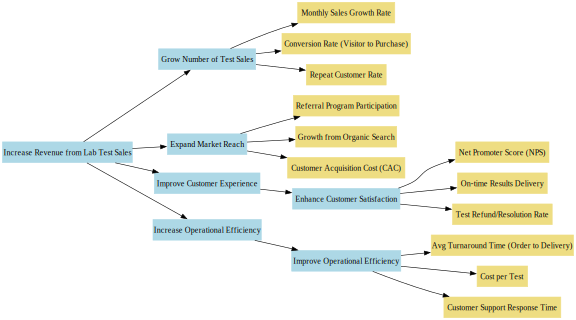

In [9]:

# Define the OKR Tree in Graphviz format
dot = graphviz.Digraph(format='png')
dot.attr(size='8,10')  # Adjust size for better readability within notebook
dot.attr(rankdir='LR')  # Change layout to left-to-right (horizontal structure)

# Objective 1: Increase Revenue from Lab Test Sales
dot.node('A', 'Increase Revenue from Lab Test Sales', shape='box', style='filled', color='lightblue')

# Key Results for Revenue Objective
dot.node('B', 'Grow Number of Test Sales', shape='box', style='filled', color='lightblue')
dot.node('C', 'Expand Market Reach', shape='box', style='filled', color='lightblue')

# Metrics for Grow Number of Test Sales
dot.node('D', 'Monthly Sales Growth Rate', shape='box', style='filled', color='lightgoldenrod')
dot.node('E', 'Conversion Rate (Visitor to Purchase)', shape='box', style='filled', color='lightgoldenrod')
dot.node('F', 'Repeat Customer Rate', shape='box', style='filled', color='lightgoldenrod')

# Metrics for Expand Market Reach
dot.node('G', 'Referral Program Participation', shape='box', style='filled', color='lightgoldenrod')
dot.node('H', 'Growth from Organic Search', shape='box', style='filled', color='lightgoldenrod')
dot.node('I', 'Customer Acquisition Cost (CAC)', shape='box', style='filled', color='lightgoldenrod')

# Objective 2: Improve Customer Experience
dot.node('J', 'Improve Customer Experience', shape='box', style='filled', color='lightblue')

# Key Results for Customer Experience Objective
dot.node('K', 'Enhance Customer Satisfaction', shape='box', style='filled', color='lightblue')

# Metrics for Enhance Customer Satisfaction
dot.node('L', 'Net Promoter Score (NPS)', shape='box', style='filled', color='lightgoldenrod')
dot.node('M', 'On-time Results Delivery', shape='box', style='filled', color='lightgoldenrod')
dot.node('N', 'Test Refund/Resolution Rate', shape='box', style='filled', color='lightgoldenrod')

# Objective 3: Increase Operational Efficiency
dot.node('O', 'Increase Operational Efficiency', shape='box', style='filled', color='lightblue')

# Key Results for Operational Efficiency
dot.node('P', 'Improve Operational Efficiency', shape='box', style='filled', color='lightblue')

# Metrics for Improve Operational Efficiency
dot.node('Q', 'Avg Turnaround Time (Order to Delivery)', shape='box', style='filled', color='lightgoldenrod')
dot.node('R', 'Cost per Test', shape='box', style='filled', color='lightgoldenrod')
dot.node('S', 'Customer Support Response Time', shape='box', style='filled', color='lightgoldenrod')

# Relationships
dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('B', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('C', 'G')
dot.edge('C', 'H')
dot.edge('C', 'I')

dot.edge('A', 'J')
dot.edge('J', 'K')
dot.edge('K', 'L')
dot.edge('K', 'M')
dot.edge('K', 'N')

dot.edge('A', 'O')
dot.edge('O', 'P')
dot.edge('P', 'Q')
dot.edge('P', 'R')
dot.edge('P', 'S')

# Display the graph within the notebook
display(dot)
